### Plot 1: The predictive potential of rank difference 


In [4]:
from IPython.display import display, HTML
display(HTML('''<img src="image1.png",width=800,height=600>'''))

**Description:**  The most obvious feature by which to predict the outcome of a match is to use the difference in player ranking.  To assign these rankings, the Association of Tennis Professionals (ATP) assign "ranking points" to players each time they win a match, with extra points awarded for upsets and important victories.  Players are then ranked according to who has the most ranking points.  It is not apriori obvious, however, to what extent rank differences function as a predictive tool, nor how such derived prediction might compare to those implied by open betting markets.  The following figure provides three different ways to think about these questions.  

The left hand figure shows a probability curve that emerges from a logistic regression on rank point differences.  The $x-$axis represents the absolute value of the difference in rank points, scaled by its standard deviation.  The logistic curve is superimposed over a histogram of empircal probabalities, achieved by binning match outcomes by some discrete subsample of scaled rank-point differences. The plot highlights where and to what extent the logistic curve succeeds in matching empirical probabilities.  

The center plot shows the same curve superimposed over a scatterplot of the probabilities implied by the odds markets.  The scatterplot is achieved by taking the latest published odds for each winner, transforming them to probabilities, and plotting against the scaled difference in rank points.  This plot illustrates the extent to which the single, rank-based logistic probability needs to serve as proxy for the host of probabilities emerging from the odds market.  

The right hand plot synthesizes the information in the center plot by showing the standard deviation of the implied probabilities, grouped along discrete samples of scaled rank point differences.  The strong negative slope of the regression line gives a rough idea of the rate at which these deviations decrease as a function of normalized rank difference.   Since our objective is to beat the odds market, the regime of maximal interest is the one where the odds market is most uncertain. 




**Code to produce the plot:**

In [2]:
import numpy as np # numerical libraries
import pandas as pd # for data analysis
import matplotlib as mpl # a big library with plotting functionality
import matplotlib.pyplot as plt # a subset of matplotlib with most of the useful tools
import IPython as IP
%matplotlib inline 
import pdb
from sklearn import linear_model as lm

Load data and take a peak at it.  

In [3]:
odds= pd.read_pickle('../data/pickle_files/odds.pkl')
matches= pd.read_pickle('../data/pickle_files/matches.pkl')
data = pd.merge(matches,odds[['PSW','PSL','key_o']].dropna(axis=0,subset=["PSW"]),how='inner',on='key_o')
data = data[~data.winner_rank_points.isnull() & ~data.loser_rank_points.isnull()]
IP.display.display(data[0:3])

,tourney_id,size,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num_old,winner_id,winner_seed,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,match_type,key_m,key_o,match_num,PSW,PSL
0,2010-1536,55,madrid masters,Clay,56,M,2010-05-09,1,103794,NaN,...,8.0,7.0,4.0,9.0,atp_matches,0,7678,11,2.25,1.74
1,2010-1536,55,madrid masters,Clay,56,M,2010-05-09,2,104919,NaN,...,19.0,17.0,1.0,4.0,atp_matches,1,7674,7,1.64,2.46
2,2010-1536,55,madrid masters,Clay,56,M,2010-05-09,3,104527,15.0,...,11.0,10.0,3.0,9.0,atp_matches,2,7687,20,1.22,5.01


Separate data into training, validation, and test sets. (This division is not used for the plot above, but will be critical in assessing the performance of our learning algorithms.)

In [4]:
data['year'] = data['tourney_date'].map(lambda x: x.year)
training = data[data.year.isin([2010,2011,2012])]
validation = data[data.year.isin([2013,2014])]
test = data[data.year.isin([2015,2016])]

Define each match as a 1 or a 0, depending on whether the higher ranked player won.

In [5]:
# consider rank difference to be positive if winner higher ranked, otherwise negative
rank_diff = (training['winner_rank_points'] - training['loser_rank_points']).values
# if higher ranked player won, raw rank was a successful predictor
y = (rank_diff > 0)*1
# predictions done *before* the match, so algorithm operates on absolute value of rank difference 
X = np.abs(rank_diff)
# for numerical well-behavedness, we need to scale and center the data
X=(X/np.std(X,axis=0))

Perform 1-D logistic regression on training data.

In [6]:
lr = lm.LogisticRegression(C=1., solver='lbfgs')
lr.fit(X.reshape(len(X),-1),y*1)
cofs = lr.coef_[0]

Produce the plots:

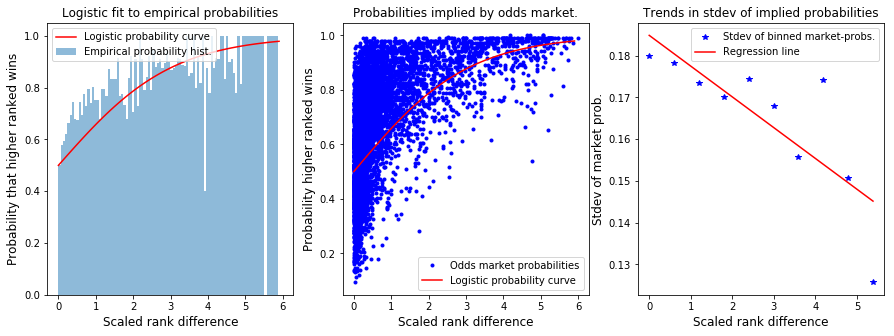

In [7]:
# define figure and axes
fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

# figure A: predicted probabilities vs. empirical probs
hist, bin_edges = np.histogram(X,bins=100)
p = [np.sum(y[np.where((X>=bin_edges[i]) & (X<bin_edges[i+1]))[0]])/np.max([hist[i],1]) for i in np.arange(len(bin_edges)-1)]
bar_pos = np.arange(len(p))
bar_width = np.diff(bin_edges)
ax0.bar(bin_edges[0:-1], p, width=bar_width, align='edge', alpha=0.5)
r = np.arange(X.min(),X.max(),.1)
s = 1/(1+np.exp(-cofs[0]*r))
ax0.plot(r,s,'r')
ax0.set_xlabel('Scaled rank difference',fontsize=12)
ax0.set_ylabel('Probability that higher ranked wins',fontsize=12)
ax0.set_title('Logistic fit to empirical probabilities',fontsize=12)
ax0.legend(['Logistic probability curve','Empirical probability hist.'])

# figure B:  probabilities predicted by odds market
ProbW = 1/training.PSW
ProbL = 1/training.PSL
idx = (training.winner_rank_points>training.loser_rank_points)
odds_prob=np.where(idx,ProbW,ProbL)
t = pd.DataFrame({'X':X,'odds_prob':odds_prob})
ts = t.sort_values('X')
ax1.plot(ts['X'],ts['odds_prob'],'.b')
ax1.plot(r,s,'r')
ax1.set_xlabel('Scaled rank difference',fontsize=12)
ax1.set_ylabel('Probability higher ranked wins',fontsize=12)
ax1.set_title('Probabilities implied by odds market.',fontsize=12)
ax1.legend(['Odds market probabilities','Logistic probability curve'])


# Fig C:  variance in odds probabilities as a function of rank difference
x_odds = ts['X'].values.reshape(len(ts),-1)
y_odds = ts['odds_prob'].values
hist, bin_edges = np.histogram(x_odds,bins=10)
stds = [np.std(y_odds[np.where((X>=bin_edges[i]) & (X<bin_edges[i+1]))]) for i in np.arange(len(bin_edges)-1)]
reg = lm.LinearRegression()
reg.fit (bin_edges[0:-1].reshape(10,1),stds)
yv=reg.predict(bin_edges[0:-1].reshape(10,1))
ax2.plot(bin_edges[0:-1],stds,'*b')
ax2.plot(bin_edges[0:-1],yv,'r')
ax2.set_xlabel('Scaled rank difference',fontsize=12)
ax2.set_ylabel('Stdev of market prob.',fontsize=12)
ax2.set_title('Trends in stdev of implied probabilities',fontsize=12)
ax2.legend(['Stdev of binned market-probs.','Regression line'])

